# PIMA diabetes Exploratory Data Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from utils import apply_scaling

from ml_class import (plot_cv_indices,
                      plot_decision_boundary,
                     plot_learning_curve,
                     multi_roc_auc_plot,
                     dict_of_models,
                     RFE_opt_rf,
                     make_confusion_matrix)

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold, cross_val_score, cross_validate, train_test_split, KFold
from sklearn.feature_selection import RFE
from sklearn.metrics import confusion_matrix, roc_curve, auc

In [2]:
if "jms_style_sheet" in plt.style.available:
    plt.style.use("jms_style_sheet")

In [3]:
df = pd.read_csv("diabetes.csv")

In [4]:
display(df.head()), display(df.shape)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


(768, 9)

(None, None)

## Plot the amount of rows in each side of the target

#### Looks like the target is imbalanced so this needs to be taken into account

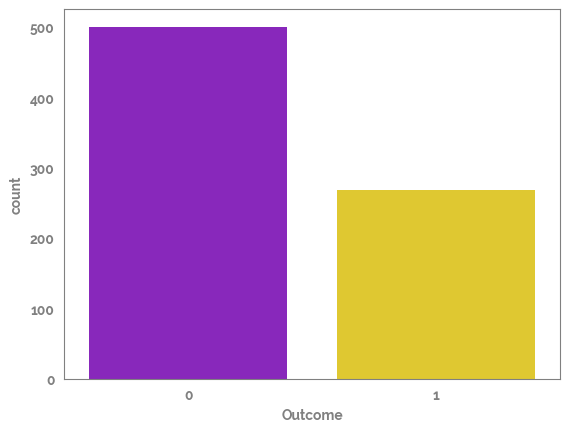

In [5]:
_ = sns.countplot(x=df["Outcome"])

In [6]:
X = df.drop("Outcome", axis=1)
y = df["Outcome"]

In [7]:
dict_of_models

[{'label': 'Logistic Regression', 'model': LogisticRegression()},
 {'label': 'Gradient Boosting', 'model': GradientBoostingClassifier()},
 {'label': 'K_Neighbors Classifier',
  'model': KNeighborsClassifier(n_neighbors=3)},
 {'label': 'SVM Classifier (linear)',
  'model': SVC(C=0.025, kernel='linear', probability=True)},
 {'label': 'SVM Classifier (Radial Basis Function; RBF)',
  'model': SVC(C=1, gamma=2, probability=True)},
 {'label': 'Gaussian Process Classifier',
  'model': GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))},
 {'label': 'Decision Tree (depth=5)',
  'model': DecisionTreeClassifier(max_depth=5)},
 {'label': 'Random Forest Classifier(depth=5)',
  'model': RandomForestClassifier(max_depth=5, max_features=1, n_estimators=10)},
 {'label': 'Multilayer Perceptron (MLP) Classifier',
  'model': MLPClassifier(alpha=1, max_iter=1000)},
 {'label': 'AdaBoost Classifier', 'model': AdaBoostClassifier()},
 {'label': 'Naive Bayes (Gaussian) Classifier', 'model': GaussianNB

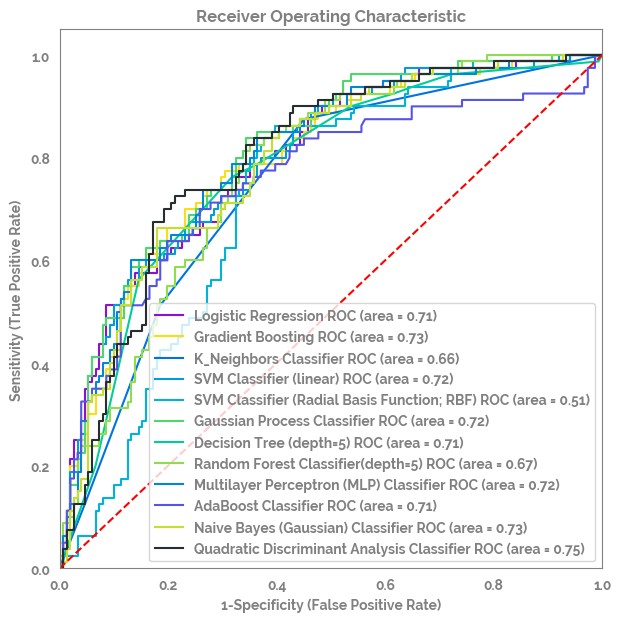

In [8]:
_ = multi_roc_auc_plot(X=X, 
                       y=y, 
                       models=dict_of_models)

In [9]:
n_features_to_select = 2 #[1, 2, 5, 10, 50, 100]
max_depth = [1, 2, 5, 10, 50, 100]
n_estimators = [1, 2, 5, 10, 50, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 300]

In [10]:
# Instanciate Random Forest
# rf = RandomForestClassifier(random_state = 42,
#                             oob_score    = False) # use oob_score with many trees

rf = GradientBoostingClassifier(random_state = 42)

# Define params_dt
params_rf = {'max_depth'    : max_depth, 
#              'n_estimators' : n_estimators,
         'max_features' : ['log2', 'auto', 'sqrt'],
#          'criterion'    : ['gini', 'entropy'], #for RandomForestClassifier
           'criterion'    : ['friedman_mse', 'mse', 'mae'] #for GradientBoostingClassifier
            }

# Instantiate grid_dt
grid_dt = GridSearchCV(estimator  = rf,
                   param_grid = params_rf,
                   scoring    = 'roc_auc',
                   cv         = 3,
                   n_jobs     = -2)

# Optimize hyperparameter
_ = grid_dt.fit(X, y)

# Extract the best estimator
optimized_rf = grid_dt.best_estimator_

# Create the RFE with a optimized random forest
# rfe = RFE(estimator            = optimized_rf, 
#           n_features_to_select = n_features_to_select,
#           verbose              = 1)

rfe = RFE(estimator            = optimized_rf, 
      n_features_to_select = n_features_to_select,
      verbose              = 1)

# Fit the eliminator to the data
_ = rfe.fit(X, y)

# create dataframe with features ranking (high = dropped early on)
feature_ranking = pd.DataFrame(data  = dict(zip(X.columns, rfe.ranking_)) , 
                           index = np.arange(0, len(X.columns)))
feature_ranking = feature_ranking.loc[0,:].sort_values()

# create dataframe with feature selected
feature_selected = X.columns[rfe.support_].to_list()

# create dataframe with importances per feature
feature_importance = pd.Series(dict(zip(X.columns, optimized_rf.feature_importances_.round(2)))) 

max_depth = optimized_rf.get_params()['max_depth']
max_features = optimized_rf.get_params()['max_features']
criterion = optimized_rf.get_params()['criterion']

Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.


In [11]:
feature_importance_df = pd.DataFrame(feature_importance.sort_values(ascending=False)).reset_index().rename(columns={"index": "feature", 0: "feature_importance"})

In [12]:
criterion, max_features, max_depth

('friedman_mse', 'log2', 2)

In [13]:
feature_importance_df

,feature,feature_importance
0,Glucose,0.40
1,BMI,0.22
2,Age,0.19
3,DiabetesPedigreeFunction,0.08
4,Insulin,0.04
5,Pregnancies,0.04
6,BloodPressure,0.02
7,SkinThickness,0.01


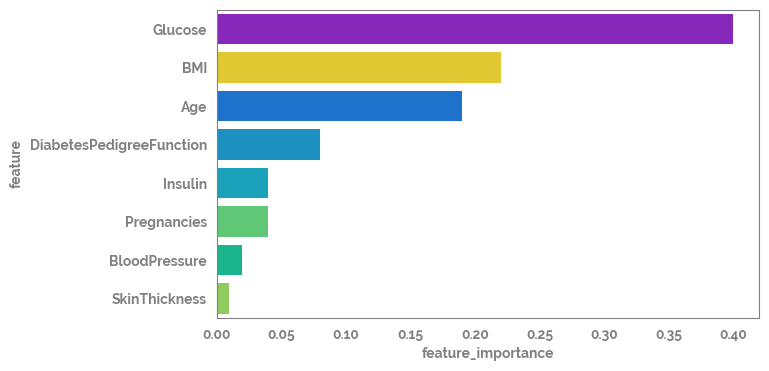

In [14]:
_ = plt.figure(figsize=(7, 4))
_ = sns.barplot(data=feature_importance_df, x="feature_importance", y="feature")
# _ = plt.savefig("images/feature_importances_diabetes_all.png", dpi=400, bbox_inches="tight")

>Train: 0=401, 1=213, Test: 0=99, 1=55


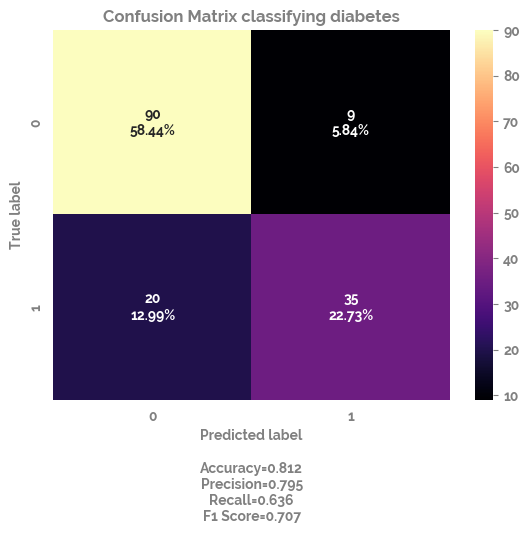

>Train: 0=400, 1=214, Test: 0=100, 1=54


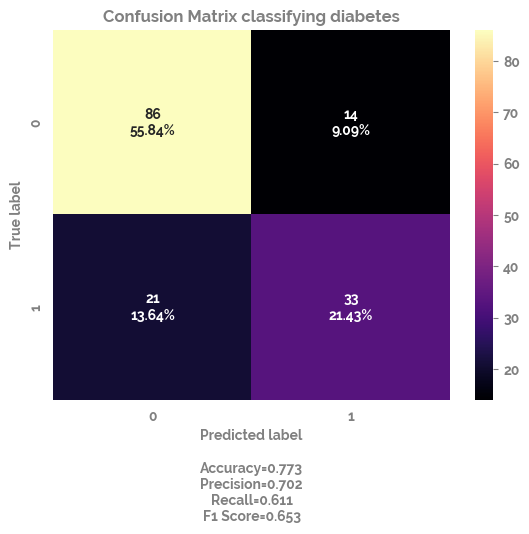

>Train: 0=399, 1=215, Test: 0=101, 1=53


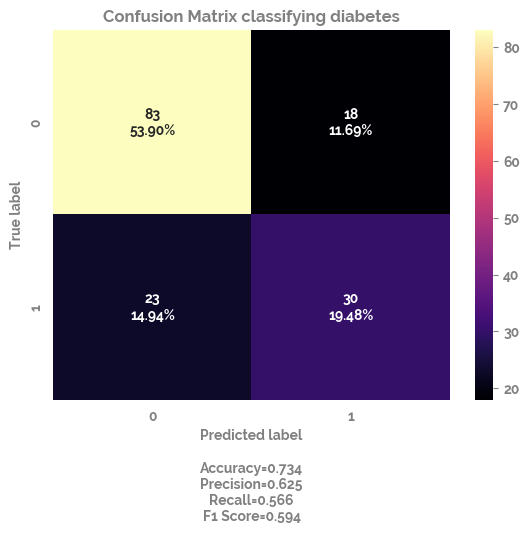

>Train: 0=397, 1=218, Test: 0=103, 1=50


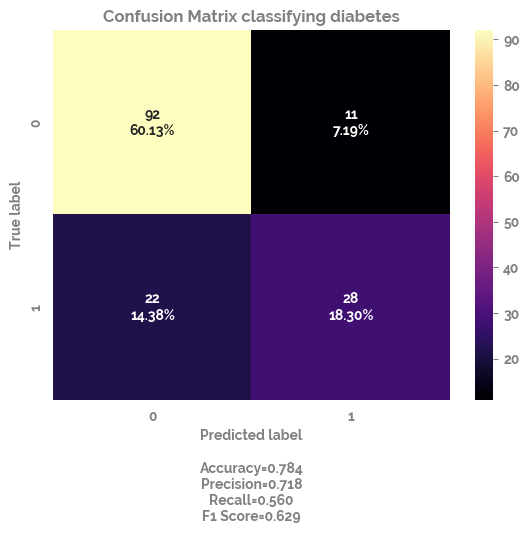

>Train: 0=403, 1=212, Test: 0=97, 1=56


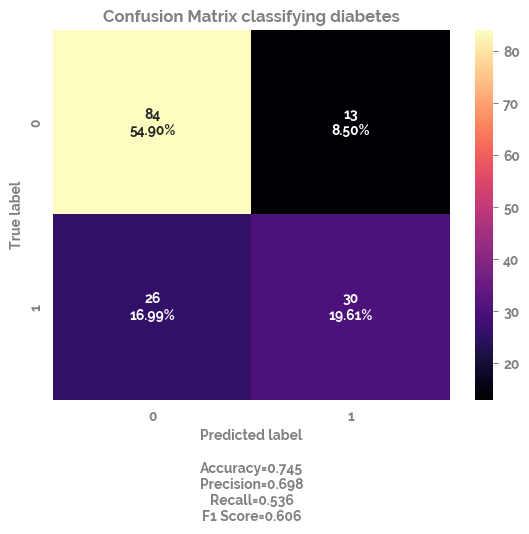

In [15]:
clf = optimized_rf

kfold = KFold(n_splits=5, shuffle=True, random_state=1)
# enumerate the splits and summarize the distributions
for train_ix, test_ix in kfold.split(X):
    # select rows
    train_X, test_X = X.loc[train_ix, :], X.loc[test_ix, :]
    train_y, test_y = y.loc[train_ix], y.loc[test_ix]
    # summarize train and test composition
    train_0, train_1 = len(train_y[train_y==0]), len(train_y[train_y==1])
    test_0, test_1 = len(test_y[test_y==0]), len(test_y[test_y==1])
    print('>Train: 0=%d, 1=%d, Test: 0=%d, 1=%d' % (train_0, train_1, test_0, test_1))
    
    _ = clf.fit(X = train_X, 
                y = train_y)
    
    pred_y = clf.predict(test_X)
    cf_matrix = confusion_matrix(test_y, pred_y)
    
    _ = make_confusion_matrix(cf=cf_matrix, 
                      title="Confusion Matrix classifying diabetes",
                     sum_stats=True,
                             cmap="magma")
    _ = plt.show()

In [16]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=1)

In [17]:
# import sklearn
# sorted(sklearn.metrics.SCORERS.keys())

In [18]:
scoring_list = ('accuracy',
 'balanced_accuracy',
 'f1',
 'f1_weighted',
 'precision',
 'precision_weighted',
 'recall',
 'recall_weighted',
 'roc_auc',
               )

In [19]:
tmp_out = cross_validate(optimized_rf, 
                         X, 
                         y, 
                         scoring=scoring_list, 
                         return_train_score=False, 
                         cv=cv, 
                         n_jobs=-1,
#                         fit_params={"sample_weight": sampling_weights} # fit_params is returning nans for some reason :/
                        )

In [20]:
pd.DataFrame(tmp_out).drop(["fit_time", "score_time"], axis=1).agg(["mean", "median", "std"]).round(3)

,test_accuracy,test_balanced_accuracy,test_f1,test_f1_weighted,test_precision,test_precision_weighted,test_recall,test_recall_weighted,test_roc_auc
mean,0.759,0.715,0.621,0.752,0.692,0.756,0.570,0.759,0.836
median,0.753,0.708,0.615,0.745,0.683,0.748,0.556,0.753,0.834
std,0.043,0.049,0.071,0.044,0.084,0.046,0.088,0.043,0.046


In [21]:
cv_metrics_df = pd.DataFrame(tmp_out).drop(["fit_time", "score_time"], axis=1).melt(var_name="Metric")

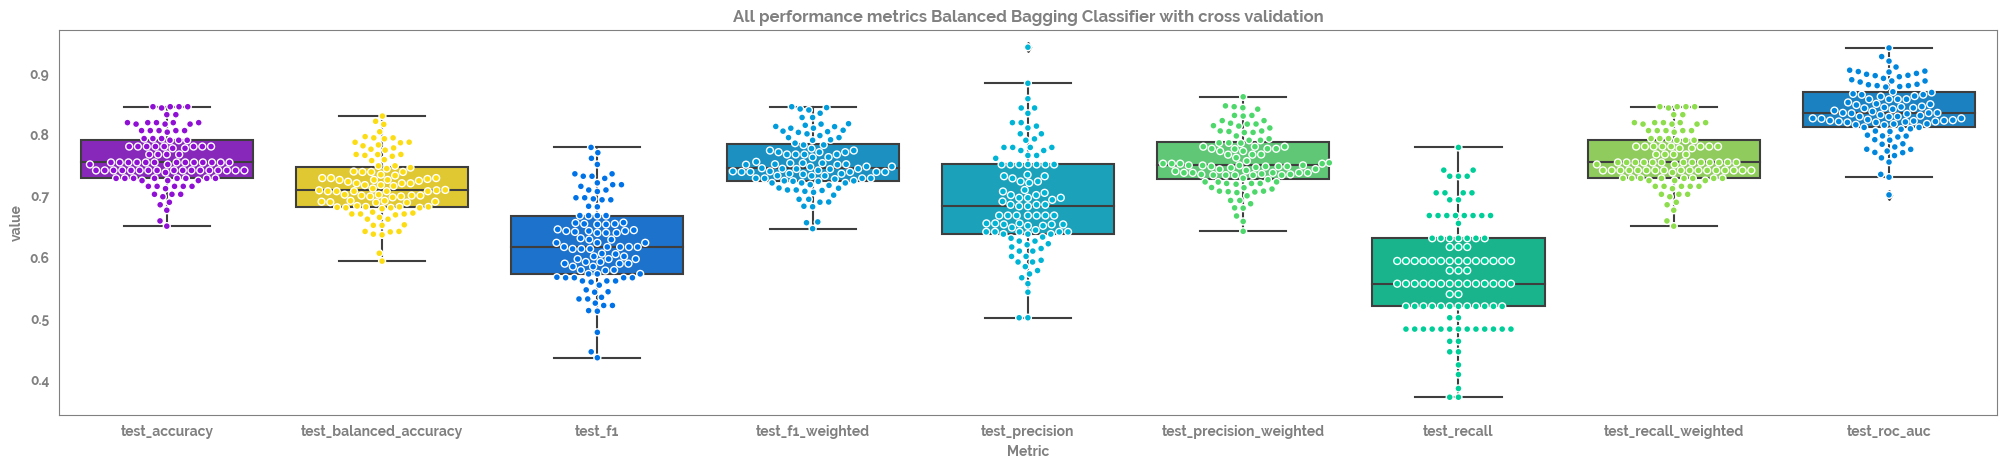

In [22]:
_ = plt.figure(figsize=(25,5))
_ = sns.boxplot(data = cv_metrics_df,
                x = "Metric",
                y = "value")
_ = sns.swarmplot(data = cv_metrics_df,
                x = "Metric",
                y = "value", edgecolor="white", linewidth=1)
_ = plt.title("All performance metrics Balanced Bagging Classifier with cross validation")

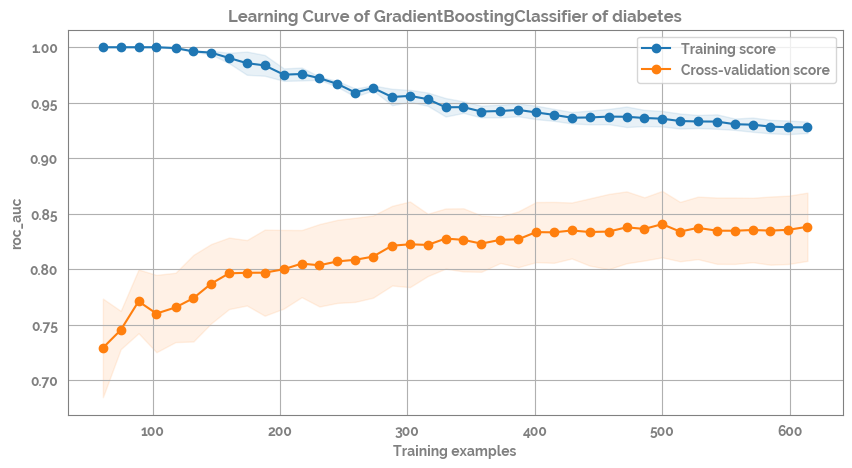

In [23]:
fig = plot_learning_curve(estimator=clf, 
                          title=f'Learning Curve of {str(optimized_rf).split("(")[0]} of diabetes',
                          X=X, 
                          y=y,
                          groups=None, 
                          cross_color="tab:orange", 
                          test_color="tab:blue", 
                          scoring='roc_auc',
                          ylim=None, 
                          cv=None, 
                          n_jobs=10, 
                          train_sizes=np.linspace(.1, 1.0, 40), 
                          figsize=(10,5))
# _ = plt.savefig(f"images/learning_curve_diabetes.png", dpi=400, bbox_inches="tight")

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)
_ = optimized_rf.fit(X_train, y_train) # train the model
y_pred = optimized_rf.predict(X_test) # predict the test data
y_pred_proba = optimized_rf.predict_proba(X_test)[:, 1] # predict the test data

In [25]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba, pos_label=1, drop_intermediate=True)

In [26]:
auc_score = auc(fpr,tpr)

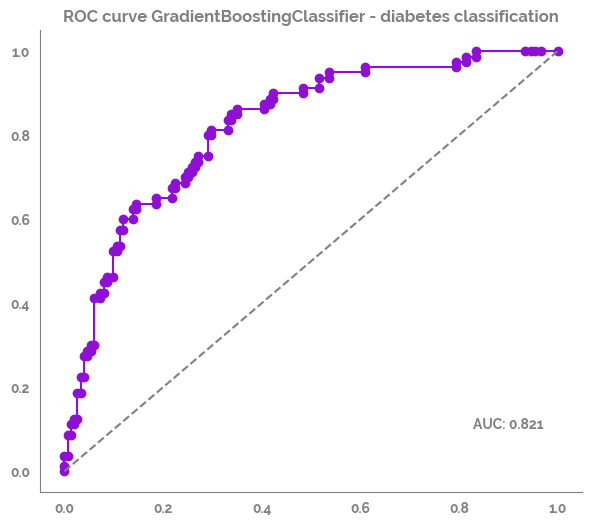

In [27]:
_ = plt.figure(figsize=(7,6))
_ = plt.plot(fpr, tpr)
_ = plt.scatter(fpr, tpr)
_ = plt.annotate(xy=(0.9, 0.1), s=f"AUC: {round(auc_score,3)}", ha="center")
_ = plt.plot([0,1], [0, 1], c="grey", ls="--")
_ = plt.title(f'ROC curve {str(optimized_rf).split("(")[0]} - diabetes classification')
_ = sns.despine()

0.8152433425160699
0.8315768542453769
0.8288383571302661
0.8456443195503813
0.8430127041742287


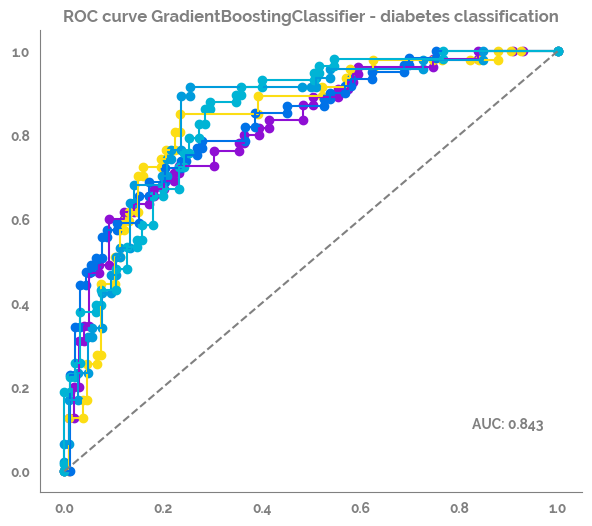

In [28]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
# enumerate the splits and summarize the distributions
_ = plt.figure(figsize=(7,6))
for train_ix, test_ix in kfold.split(X):
    # select rows
    X_train, X_test = X.loc[train_ix, :], X.loc[test_ix, :]
    y_train, y_test = y.loc[train_ix], y.loc[test_ix]

    _ = optimized_rf.fit(X_train, y_train) # train the model
    y_pred = optimized_rf.predict(X_test) # predict the test data
    y_pred_proba = optimized_rf.predict_proba(X_test)[:, 1] # predict the test data

    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba, pos_label=1, drop_intermediate=True)

    auc_score = auc(fpr,tpr)
    print(auc_score)

    _ = plt.plot(fpr, tpr)
    _ = plt.scatter(fpr, tpr)

_ = plt.annotate(xy=(0.9, 0.1), s=f"AUC: {round(auc_score,3)}", ha="center")
_ = plt.plot([0,1], [0, 1], c="grey", ls="--")
_ = plt.title(f'ROC curve {str(optimized_rf).split("(")[0]} - diabetes classification')
_ = sns.despine()

In [29]:
X = df[feature_selected]
y = df["Outcome"]

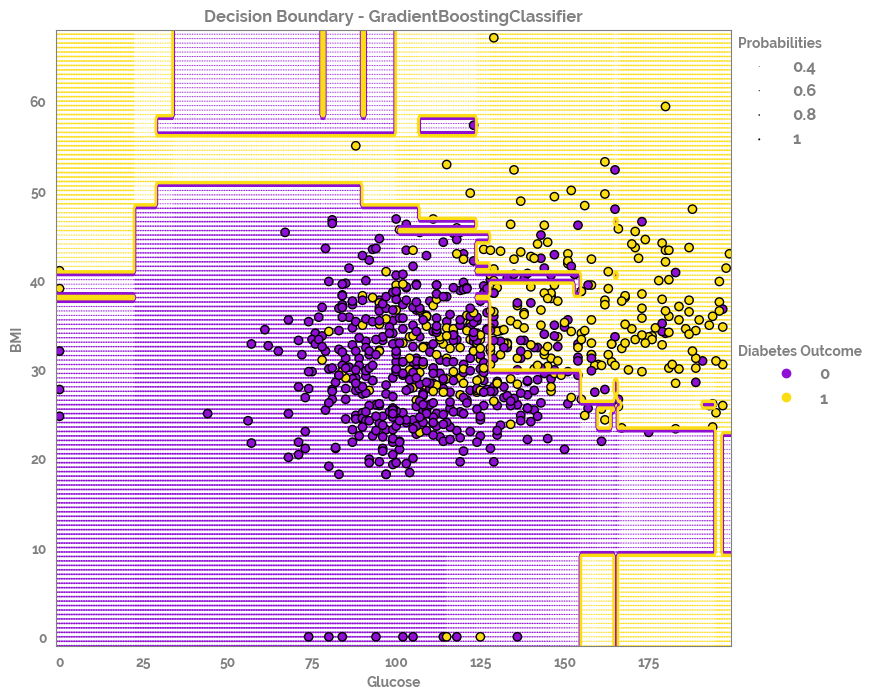

In [30]:
_ = plot_decision_boundary(X=X, 
                           y=y, 
                           clf=optimized_rf, 
                           title = f'Decision Boundary - {str(optimized_rf).split("(")[0]}', 
                           legend_title = "Diabetes Outcome",
                          h=0.5,
                          figsize=(10, 8))